##### **Assignment 09 - Applying Random Forest Algorithm on Amazon Food Review Dataset**

## **Overall Summary**


Below are few steps that I have followed while doing this assignments. 
* **Data Preprocessing -** Used the code given by AAIC in the python notebook for initial data pre-processing (Creating Clean review).
* **Feature Engineering -** Tried to replicate some of the work I have learnt in a Data Science workshop by DJ(Dipankar). Along with Character Count I have tried to implement some of the feature engineering techniques he showed in NLP. The workshop is very interesting where he has showed the one of the library called **TextBlob** to calculate the positive polarity and negative polarity which is mainly used for **Sentiment Analysis**. All the credits goes to DJ (Dipankar) for his amazing contributions in Medium, Github and great books in Text Analytics. Also I will be using some of the techniques he used in his workshops or Text Books in the future Assignments
* **Stackoverflow-** Because of non-computer science background, I have depended on this amazing coding community for some of the coding issues I faced. I have attached the Links where the logic has been taken for building / improving the models. All the credits goes to the amazing programmers who constantly answers all the questions posed on it. To mention I have tairlored these according to my requirement.

In [1]:
## Calling all the required Libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import scipy
import nltk
import textblob
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.model_selection import cross_val_score

/opt/conda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [2]:
# Python code is run in the Kaggle Kernals. We are using the below kernal to import data directly in Kaggle
filtered_data = pd.read_csv("../input/Reviews.csv")
filtered_data.shape

#We will exclude the 3 rating and include only 1 and 2 as negative rating and 4 & 5 as positive rating
filtered_data = filtered_data[filtered_data['Score'] != 3]
filtered_data.shape

# We will building the binary classification Model. So we will convert the Multi-Class into Binary Class Output
# So reviews > 3 Score is 1(positive review), and reviews < 3 Score is 0(negative rating).
# So score acts as the Binary Classification output
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [5]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

In [8]:
# https://stackoverflow.com/a/47091490/4084039
from bs4 import BeautifulSoup
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [10]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
final['CleanedText']=preprocessed_reviews #adding a column of CleanedText which displays the data after pre-processing of the review 


100%|██████████| 364171/364171 [02:18<00:00, 2622.87it/s]


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [11]:
#Sorting the data based on Time and taking the first 100K data
final.sort_values(by = ['Time'])
final_data = final.head(25000)
final_data['Score'].value_counts()

1    21204
0     3796
Name: Score, dtype: int64

In [12]:
# Separate positive and negative classes for preparing a Balanced Dataset
from sklearn.utils import resample
pos_review = final_data[final_data.Score==1]
neg_review = final_data[final_data.Score==0]

In [13]:
neg_review_upsample = resample(neg_review,replace=True,n_samples=21204,random_state=123)
neg_review_upsample.shape

(21204, 11)

In [14]:
final_balanced_data = pd.concat([pos_review, neg_review_upsample])

In [15]:
final_balanced_data.shape

(42408, 11)

# **Featurization**

## **Experiment 1 ---> Count based Features**

We will Start working on the Featurization using some of the techniques I learnt in a conference from **ANALYTICS VIDHYA by DJ (Dipankar)** . The below code snippets are the ideas of DJ in the training he presented.

A number of basic text based features can also be created which sometimes are helpful for improving text classification models. Some examples are:

* **Word Count:** total number of words in the documents.
* **Character Count:** total number of characters in the documents.
* **Average Word Density:** average length of the words used in the documents.
* **Puncutation Count:** total number of punctuation marks in the documents.
* **Upper Case Count:** total number of upper count words in the documents.
* **Title Word Count:** total number of proper case (title) words in the documents

**Source:** https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

The below codes for **COUNT Features** are tailored based on the requiremnts

In [16]:
final_balanced_data['char_count'] = final_balanced_data['Text'].apply(len)
final_balanced_data['word_count'] = final_balanced_data['Text'].apply(lambda x: len(x.split()))
final_balanced_data['char_density']=final_balanced_data['char_count']/(final_balanced_data['word_count']+1)
final_balanced_data['upper_case_word_count'] = final_balanced_data['Text'].apply(lambda x: len([word for word in x.split() if word.isupper()]))

In [17]:
final_balanced_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,char_count,word_count,char_density,upper_case_word_count
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,375,74,5.000000,1
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...,260,48,5.306122,2
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...,182,35,5.055556,1


## **Experiment - 2 --> Features from Sentiment Analysis**

TextBlob is an excellent open-source library for performing NLP tasks with ease, including sentiment analysis. It also an a sentiment lexicon (in the form of an XML file) which it leverages to give both polarity and subjectivity scores.

* The polarity score is a float within the range [-1.0, 1.0].
* The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.
* Perhaps this could be used for getting some new features? Let's look at some basic examples.

Source: https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

The below codes for **COUNT Features** are tailored based on the requiremnts

In [18]:
review_senti_objective = final_balanced_data['Text'].apply(lambda row: textblob.TextBlob(row).sentiment)
final_balanced_data['polarity'] = [obj.polarity for obj in review_senti_objective.values]
final_balanced_data['subjectivity'] = [obj.polarity for obj in review_senti_objective.values]

In [19]:
final_balanced_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,char_count,word_count,char_density,upper_case_word_count,polarity,subjectivity
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,375,74,5.000000,1,0.251726,0.251726
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...,260,48,5.306122,2,0.201667,0.201667
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...,182,35,5.055556,1,0.375000,0.375000


### Split the Reviews into before applying the Featurization Techniques

In [20]:
## Let's split the reviews into Train Data and Test Data before using Featurization Techniques
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(final_balanced_data, test_size = 0.30, random_state = 0)

In [21]:
x_train.shape

(29685, 17)

In [22]:
#Lets convert the Sparse Matrix into the Dense matrix and merge back to the Original Data.
y_train = x_train['Score']
y_test = x_test['Score']

In [23]:
print("The Shape Y_train and Y_Test is -- ",y_train.shape,y_test.shape)

The Shape Y_train and Y_Test is --  (29685,) (12723,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [24]:
#BoW
#Let's build the BoW seperately for both Train and Test Data 
Bow_Vect = CountVectorizer(max_features = 3000)
Bow_Vector_Train = Bow_Vect.fit_transform(x_train['CleanedText'].values)
Bow_Vector_Test  = Bow_Vect.transform(x_test['CleanedText'].values)

In [25]:
#Let's check the dimenstion of the BOW vectorizer we build both on Train Data and Test Data
print("Shape of Decision Tree Train & Test Review Data Vectorizer",Bow_Vector_Train.get_shape(), " & ",Bow_Vector_Test.get_shape())
print("***************************************************************************************************")
# Get the Type of the data 
print("Type of  Decision Tree Train & Test Data",type(Bow_Vector_Train)," & ", type(Bow_Vector_Test))

Shape of Decision Tree Train & Test Review Data Vectorizer (29685, 3000)  &  (12723, 3000)
***************************************************************************************************
Type of  Decision Tree Train & Test Data <class 'scipy.sparse.csr.csr_matrix'>  &  <class 'scipy.sparse.csr.csr_matrix'>


**Code Reference - **Used the below reference to understand how to add the extra Pandas column to a Sparse Matrix that is the Features like Word count, Word Density etc., to the existing Sparse matrices we created from the Bag of words and Tfidf.

https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix

In [26]:
#https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
from scipy.sparse import hstack
Bow_train_withFE = hstack((Bow_Vector_Train,np.array(x_train['word_count'])[:,None]))
Bow_train_withFE = hstack((Bow_train_withFE,np.array(x_train['char_count'])[:,None]))
Bow_train_withFE = hstack((Bow_train_withFE,np.array(x_train['char_density'])[:,None]))
Bow_train_withFE = hstack((Bow_train_withFE,np.array(x_train['polarity'])[:,None]))
Bow_train_withFE = hstack((Bow_train_withFE,np.array(x_train['subjectivity'])[:,None]))
print("Before and after Feature Engineering the Features Dimension is -",Bow_train_withFE.get_shape(),"&",Bow_Vector_Train.get_shape())

Before and after Feature Engineering the Features Dimension is - (29685, 3005) & (29685, 3000)


In [27]:
#https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
Bow_test_withFE = hstack((Bow_Vector_Test,np.array(x_test['word_count'])[:,None]))
Bow_test_withFE = hstack((Bow_test_withFE,np.array(x_test['char_count'])[:,None]))
Bow_test_withFE = hstack((Bow_test_withFE,np.array(x_test['char_density'])[:,None]))
Bow_test_withFE = hstack((Bow_test_withFE,np.array(x_test['polarity'])[:,None]))
Bow_test_withFE = hstack((Bow_test_withFE,np.array(x_test['subjectivity'])[:,None]))
print("Before and after Feature Engineering the Features Dimension is -",Bow_test_withFE.get_shape(),"&",Bow_Vector_Test.get_shape())

Before and after Feature Engineering the Features Dimension is - (12723, 3005) & (12723, 3000)


So after adding the New Features using few Feature engineering techniques, below is the dimension of Train & Test datasets before and after the Feature Engineering.

In [28]:
print("Shape of the Sparse Data before the Feature Engineering -",Bow_Vector_Train.get_shape(),"&",Bow_Vector_Test.get_shape())
print("=========================================================================================")
print("Shape of the Sparse Data after  the Feature Engineering -",Bow_train_withFE.get_shape(),"&",Bow_test_withFE.get_shape())

Shape of the Sparse Data before the Feature Engineering - (29685, 3000) & (12723, 3000)
Shape of the Sparse Data after  the Feature Engineering - (29685, 3005) & (12723, 3005)


## [4.2] TF-IDF

In [29]:
tf_idf_vect = TfidfVectorizer(max_features = 3000)

tfidf_train = tf_idf_vect.fit_transform(x_train['CleanedText'].values)
tfidf_test = tf_idf_vect.transform(x_test['CleanedText'].values)

print('='*80)
print("The Shape of TFIDF Count Vectorizer is --> ",tfidf_train.get_shape(), " and ", tfidf_test.get_shape())
print('='*80)

The Shape of TFIDF Count Vectorizer is -->  (29685, 3000)  and  (12723, 3000)


In [30]:

tfidf_train_with_FE = hstack((tfidf_train,np.array(x_train['word_count'])[:,None]))
tfidf_train_with_FE = hstack((tfidf_train_with_FE,np.array(x_train['char_count'])[:,None]))
tfidf_train_with_FE = hstack((tfidf_train_with_FE,np.array(x_train['char_density'])[:,None]))
tfidf_train_with_FE = hstack((tfidf_train_with_FE,np.array(x_train['polarity'])[:,None]))
tfidf_train_with_FE = hstack((tfidf_train_with_FE,np.array(x_train['subjectivity'])[:,None]))
print("Before and after Feature Engineering the Features Dimension is -",tfidf_train_with_FE.get_shape(),"&",tfidf_train.get_shape())

Before and after Feature Engineering the Features Dimension is - (29685, 3005) & (29685, 3000)


In [31]:
#https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
tfidf_test_with_FE = hstack((tfidf_test,np.array(x_test['word_count'])[:,None]))
tfidf_test_with_FE = hstack((tfidf_test_with_FE,np.array(x_test['char_count'])[:,None]))
tfidf_test_with_FE = hstack((tfidf_test_with_FE,np.array(x_test['char_density'])[:,None]))
tfidf_test_with_FE = hstack((tfidf_test_with_FE,np.array(x_test['polarity'])[:,None]))
tfidf_test_with_FE = hstack((tfidf_test_with_FE,np.array(x_test['subjectivity'])[:,None]))
print("Before and after Feature Engineering the Features Dimension is -",tfidf_test_with_FE.get_shape(),"&",tfidf_test.get_shape())

Before and after Feature Engineering the Features Dimension is - (12723, 3005) & (12723, 3000)


## [4.3] Word2Vec

In [32]:
# Train your own Word2Vec model using your own Train text corpus
i=0
train_corpus=[]
for sentance in x_train['CleanedText'].values:
    train_corpus.append(sentance.split())

# Train your own Word2Vec model using your own Test text corpus
i=0
test_corpus=[]
for sentance in x_test['CleanedText'].values:
    test_corpus.append(sentance.split())

print(len(train_corpus)," & ",len(test_corpus))

29685  &  12723


In [33]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(train_corpus,min_count=5,size=300, workers=4)
w2v_model=Word2Vec(test_corpus, min_count=5,size=300, workers=4)

In [34]:
w2v_words = list(w2v_model.wv.vocab)
print("Number of words that occured minimum 5 times are --> ",len(w2v_words))
print("===========================================================")
print("Sample words are --- ")
print("                     ")
print(w2v_words[0:100])

Number of words that occured minimum 5 times are -->  8006
Sample words are --- 
                     
['espresso', 'beans', 'roasted', 'different', 'ways', 'lavazza', 'illy', 'represent', 'best', 'two', 'roasting', 'italian', 'roasts', 'longer', 'time', 'lower', 'temperature', 'result', 'higher', 'darker', 'according', 'people', 'robust', 'properly', 'ground', 'brewed', 'bit', 'stronger', 'tasting', 'also', 'little', 'bitter', 'pure', 'black', 'color', 'done', 'hint', 'licorice', 'aftertaste', 'personally', 'though', 'prefer', 'approach', 'giving', 'coffee', 'four', 'rather', 'five', 'stars', 'even', 'certainly', 'recognize', 'high', 'quality', 'opinion', 'widely', 'available', 'dark', 'opposed', 'medium', 'like', 'terrible', 'product', 'days', 'not', 'get', 'thing', 'stay', 'cocked', 'watched', 'videos', 'read', 'excellent', 'reviews', 'etc', 'still', 'releases', 'safety', 'latch', 'never', 'got', 'close', 'putting', 'bought', 'pay', 'shipping', 'back', 'box', 'take', 'remainder', 'm

## [4.4] Avg.Word2Vec

In [35]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(train_corpus): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent:# for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 29685/29685 [00:05<00:00, 5616.37it/s]

29685
300


In [36]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(test_corpus): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 12723/12723 [00:02<00:00, 5746.19it/s]

12723
300


In [37]:
import pandas as pd
avgw2v_train = pd.DataFrame(sent_vectors)
avgw2v_test  = pd.DataFrame(sent_vectors_test)
print(sent_vectors[1])
print("*"*50)
print(sent_vectors_test[1])
print(type(avgw2v_train) ,"&", type(avgw2v_test))
print(len(avgw2v_train), "&", len(avgw2v_test))

[ 1.34301729e-01 -2.06032786e-01 -2.15032694e-01  6.94420128e-02
 -1.90614000e-01  1.75170973e-02 -4.24926607e-02 -1.61665817e-01
 -1.96202533e-01 -5.77193177e-03  1.79304545e-01  2.04268374e-01
 -1.96369660e-02 -1.33992855e-01 -2.65473760e-02  1.26715293e-01
 -1.12903428e-01  1.61462366e-01  5.03703955e-01  1.90096888e-03
  2.18914465e-01  1.34967754e-01  9.73813843e-02 -2.07619650e-01
  1.00747409e-01  3.00579425e-01 -9.02205775e-02  1.26151321e-01
 -4.41095474e-02 -8.52466420e-02  2.13134441e-01  2.05431215e-01
  2.01177872e-01  8.64813432e-02  2.18564183e-01 -1.20202884e-01
  1.64586700e-01 -1.64854772e-01 -1.80197213e-01 -1.05625976e-01
 -3.98556271e-02 -3.55149175e-02  1.21977449e-01 -6.53550787e-02
  6.90124348e-02 -1.86932151e-01 -1.27909981e-01  6.00261749e-02
 -4.51565165e-01 -8.88346073e-02 -4.99463956e-02  1.60240527e-01
  2.06906592e-02 -1.29975668e-01 -1.55097504e-01 -1.07552244e-02
  1.44668693e-01  1.23814232e-02 -5.58961619e-02  6.77995939e-02
 -6.72290590e-02  1.07697

In [38]:
avgw2v_train.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0.065883,-0.113225,-0.215068,0.176954,-0.128913,0.158316,-0.047786,-0.013226,-0.239786,-0.038166,0.278404,0.101752,0.002274,-0.123726,0.000558,0.133054,-0.028405,0.151664,0.306114,0.052522,0.177222,0.137239,0.029563,-0.184738,-0.040370,0.268715,0.188200,0.161191,-0.121536,0.075144,0.126077,0.246358,-0.054359,-0.005426,0.149941,-0.063477,0.118780,-0.046145,-0.276033,-0.001757,...,-0.098040,0.225373,0.050551,-0.185109,0.083508,-0.043147,0.367053,-0.021058,-0.215445,0.156286,0.171265,0.141278,0.212093,0.079030,-0.018747,-0.125427,0.076438,0.348554,0.188231,-0.187825,-0.107619,-0.134284,0.017283,-0.169463,0.045452,0.285597,0.093197,0.120726,0.024031,-0.062075,-0.047664,0.186699,-0.091193,-0.123879,-0.142443,-0.165075,0.120868,-0.044362,-0.037821,-0.097109
1,0.134302,-0.206033,-0.215033,0.069442,-0.190614,0.017517,-0.042493,-0.161666,-0.196203,-0.005772,0.179305,0.204268,-0.019637,-0.133993,-0.026547,0.126715,-0.112903,0.161462,0.503704,0.001901,0.218914,0.134968,0.097381,-0.207620,0.100747,0.300579,-0.090221,0.126151,-0.044110,-0.085247,0.213134,0.205431,0.201178,0.086481,0.218564,-0.120203,0.164587,-0.164855,-0.180197,-0.105626,...,-0.128401,0.257527,0.108081,-0.032947,0.223079,0.025194,0.448079,-0.003797,-0.453581,0.273963,0.165312,0.023479,0.256291,-0.002973,0.025763,-0.178982,0.068969,0.313677,0.222460,-0.138264,-0.180403,-0.116974,0.022678,-0.318451,0.149399,0.386978,0.109481,-0.160097,-0.080722,-0.107346,0.011112,0.198691,-0.108507,-0.271153,-0.112686,-0.187008,0.091825,-0.126172,-0.162854,-0.046180
2,-0.025858,-0.133126,-0.186381,-0.027590,-0.102931,0.161300,-0.025149,-0.062900,-0.240209,-0.004389,0.399922,0.165410,-0.046044,-0.087859,0.044504,0.043872,0.021596,0.152507,0.296406,0.178504,0.155191,0.133186,0.052799,-0.136094,-0.000912,0.234807,0.202985,0.177290,-0.101887,0.017615,0.103247,0.226141,0.037857,0.082383,0.083988,-0.132349,0.057694,-0.049706,-0.235271,-0.044663,...,0.041608,0.261475,0.014016,-0.152113,0.160111,-0.015761,0.438925,0.023378,-0.317079,0.242601,0.109124,0.035890,0.141358,-0.052160,0.008741,-0.193033,-0.032354,0.295648,0.133852,-0.054711,-0.124722,-0.095330,0.127542,-0.198701,0.085550,0.236179,0.066246,0.044035,0.033503,-0.202256,-0.132569,0.159760,-0.177598,-0.062224,-0.038998,-0.118547,0.063830,-0.082850,-0.061671,-0.044442


In [39]:
avgw2v_train_with_FE = np.column_stack((avgw2v_train,np.array(x_train['word_count'])))
avgw2v_train_with_FE = np.column_stack((avgw2v_train_with_FE,np.array(x_train['char_count'])))
avgw2v_train_with_FE = np.column_stack((avgw2v_train_with_FE,np.array(x_train['char_density'])))
avgw2v_train_with_FE = np.column_stack((avgw2v_train_with_FE,np.array(x_train['polarity'])))
avgw2v_train_with_FE = np.column_stack((avgw2v_train_with_FE,np.array(x_train['subjectivity'])))
print("Before and after Feature Engineering the Type is - ",type(avgw2v_train_with_FE), "&", type(avgw2v_train))
print("Before and after Feature Engineering the Features Dimension is - ",len(avgw2v_train_with_FE),"&",len(avgw2v_train))
print("Before and after Feature Engineering the Features Dimension is - ",len(avgw2v_train_with_FE[1]),"&",len(avgw2v_train[1]))

Before and after Feature Engineering the Type is -  <class 'numpy.ndarray'> & <class 'pandas.core.frame.DataFrame'>
Before and after Feature Engineering the Features Dimension is -  29685 & 29685
Before and after Feature Engineering the Features Dimension is -  305 & 29685


In [40]:
avgw2v_test_with_FE = np.column_stack((avgw2v_test,np.array(x_test['word_count'])))
avgw2v_test_with_FE = np.column_stack((avgw2v_test_with_FE,np.array(x_test['char_count'])))
avgw2v_test_with_FE = np.column_stack((avgw2v_test_with_FE,np.array(x_test['char_density'])))
avgw2v_test_with_FE = np.column_stack((avgw2v_test_with_FE,np.array(x_test['polarity'])))
avgw2v_test_with_FE = np.column_stack((avgw2v_test_with_FE,np.array(x_test['subjectivity'])))
print("Before and after Feature Engineering the Type is - ",type(avgw2v_test_with_FE), "&", type(avgw2v_test))
print("Before and after Feature Engineering the Features Dimension is -",len(avgw2v_test_with_FE),"&",len(avgw2v_test))
print("Before and after Feature Engineering the Features Dimension is -",len(avgw2v_test_with_FE[1]),"&",len(avgw2v_test[1]))

Before and after Feature Engineering the Type is -  <class 'numpy.ndarray'> & <class 'pandas.core.frame.DataFrame'>
Before and after Feature Engineering the Features Dimension is - 12723 & 12723
Before and after Feature Engineering the Features Dimension is - 305 & 12723


#### [4.4.1.2] TFIDF weighted W2v

In [41]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_train = model.fit_transform(x_train['CleanedText'].values)
tf_idf_test = model.transform(x_test['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [42]:
print(tf_idf_train.shape)
print(tf_idf_test.shape)

(29685, 29700)
(12723, 29700)


In [43]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(train_corpus): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 29685/29685 [07:43<00:00, 64.07it/s]


In [44]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(test_corpus): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 12723/12723 [03:20<00:00, 63.42it/s]


In [45]:
tfidf_w2v_train = tfidf_sent_vectors
tfidf_w2v_test  = tfidf_sent_vectors_test
print(tfidf_w2v_train[1])
print("="*80)
print(tfidf_w2v_test[1])

[ 1.33202401e-01 -2.02910270e-01 -2.15554611e-01  3.10608921e-02
 -2.00773244e-01 -1.83195897e-02 -1.78426529e-02 -2.00882403e-01
 -1.99698921e-01 -5.34875217e-03  1.77982733e-01  2.20225710e-01
 -4.38255527e-03 -1.31425938e-01 -2.46871542e-02  1.29197586e-01
 -1.37241615e-01  1.37037891e-01  5.25579433e-01  2.50213798e-02
  2.12028067e-01  1.33806583e-01  9.80259294e-02 -1.78660071e-01
  1.16378856e-01  2.71293805e-01 -1.23477379e-01  1.33561961e-01
 -4.43886372e-02 -1.19253542e-01  1.84495340e-01  2.11152012e-01
  2.58114497e-01  1.17149088e-01  1.98601528e-01 -1.46021880e-01
  1.61726652e-01 -1.86259843e-01 -1.41334826e-01 -1.16442145e-01
 -6.00740017e-02 -5.05952582e-02  1.45144798e-01 -5.12238739e-02
  7.13579682e-02 -1.65477107e-01 -1.36618449e-01  5.86921053e-02
 -4.39216575e-01 -7.04021298e-02 -1.97862110e-02  1.52654684e-01
  1.01132950e-02 -1.38252547e-01 -1.05344304e-01 -4.09547808e-02
  1.29702106e-01  1.69184539e-03 -3.34438171e-02  5.22895324e-02
 -6.09353465e-02  1.05523

In [46]:
tfidf_w2v_train = pd.DataFrame(tfidf_w2v_train)
tfidf_w2v_test = pd.DataFrame(tfidf_w2v_test)
print(tfidf_w2v_train.shape, tfidf_w2v_test.shape)

(29685, 300) (12723, 300)


In [47]:
tfidf_w2v_train_with_FE = np.column_stack((tfidf_w2v_train,np.array(x_train['word_count'])))
tfidf_w2v_train_with_FE = np.column_stack((tfidf_w2v_train_with_FE,np.array(x_train['char_count'])))
tfidf_w2v_train_with_FE = np.column_stack((tfidf_w2v_train_with_FE,np.array(x_train['char_density'])))
tfidf_w2v_train_with_FE = np.column_stack((tfidf_w2v_train_with_FE,np.array(x_train['polarity'])))
tfidf_w2v_train_with_FE = np.column_stack((tfidf_w2v_train_with_FE,np.array(x_train['subjectivity'])))
print("Before and after Feature Engineering the Type is - ",type(tfidf_w2v_train_with_FE), "&", type(tfidf_w2v_train))
print("Before and after Feature Engineering the Features Dimension is - ",len(tfidf_w2v_train_with_FE),"&",len(tfidf_w2v_train))
print("Before and after Feature Engineering the Features Dimension is - ",len(tfidf_w2v_train_with_FE[1]),"&",len(tfidf_w2v_train[1]))

Before and after Feature Engineering the Type is -  <class 'numpy.ndarray'> & <class 'pandas.core.frame.DataFrame'>
Before and after Feature Engineering the Features Dimension is -  29685 & 29685
Before and after Feature Engineering the Features Dimension is -  305 & 29685


In [48]:
tfidf_w2v_test_with_FE = np.column_stack((tfidf_w2v_test,np.array(x_test['word_count'])))
tfidf_w2v_test_with_FE = np.column_stack((tfidf_w2v_test_with_FE,np.array(x_test['char_count'])))
tfidf_w2v_test_with_FE = np.column_stack((tfidf_w2v_test_with_FE,np.array(x_test['char_density'])))
tfidf_w2v_test_with_FE = np.column_stack((tfidf_w2v_test_with_FE,np.array(x_test['polarity'])))
tfidf_w2v_test_with_FE = np.column_stack((tfidf_w2v_test_with_FE,np.array(x_test['subjectivity'])))
print("Before and after Feature Engineering the Type is - ",type(tfidf_w2v_test_with_FE), "&", type(tfidf_w2v_test))
print("Before and after Feature Engineering the Features Dimension is -",len(tfidf_w2v_test_with_FE),"&",len(tfidf_w2v_test))
print("Before and after Feature Engineering the Features Dimension is -",len(tfidf_w2v_test_with_FE[1]),"&",len(tfidf_w2v_test[1]))

Before and after Feature Engineering the Type is -  <class 'numpy.ndarray'> & <class 'pandas.core.frame.DataFrame'>
Before and after Feature Engineering the Features Dimension is - 12723 & 12723
Before and after Feature Engineering the Features Dimension is - 305 & 12723


## GBDT - Model Function

** GridSearch **

In [49]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
def Grid_Search_CV(x_data, y_data, Kfold = 5):
    cv_scores = []
    hyperparam = []
    param_grid = {'n_estimators': [5, 10],'max_depth': [1, 5, 10]}
    rf = GradientBoostingClassifier()
    model = GridSearchCV(rf, param_grid, cv=Kfold, scoring= 'roc_auc')
    model.fit(x_data, y_data)
    cv_results = model.cv_results_['mean_test_score']
    cv_results = pd.DataFrame(model.cv_results_).loc[:, ['mean_test_score', 'params']].sort_values(by='mean_test_score')
    param_split = cv_results['params'].apply(pd.Series)
    cv_all_scores = pd.concat([cv_results,param_split], axis = 1)
    best_parameters = model.best_params_
    best_grid_estimator = model.best_estimator_
    best_auc_score = model.best_score_
    return best_parameters, best_grid_estimator, best_auc_score, cv_all_scores

In [50]:
from sklearn.metrics import roc_auc_score
def Auc_all_data(x_data, y_data):
    #dec_tree = DecisionTreeClassifier()
    n_estimators = [5, 10]
    max_depth = [1, 5, 10]
    cv_scores = []
    row = []
    all_data_cv_score = pd.DataFrame(columns = ['max_depth','n_estimators','cv_score'])
    print("================================================================================================")
    print("The Auc score for whole X_Trian data for different max_depth & n_estimators is ----------->")
    print("================================================================================================")
    for depth in (max_depth):
        for samp in (n_estimators): 
            rf = GradientBoostingClassifier(max_depth = depth, n_estimators = samp)
            rf.fit(x_data, y_data)
            pred = rf.predict_proba(x_data)
            cv = roc_auc_score(y_data, pred[:,1])
            cv_scores.append(cv)
            all_data_cv_score = all_data_cv_score.append({'max_depth': depth, 'n_estimators': samp, 'cv_score': cv}, ignore_index=True)
    print(all_data_cv_score)
    return cv_scores, all_data_cv_score

In [51]:
def feature_importance(vector,optimal_NB):    
    feature_names =vector.get_feature_names()
    prob = optimal_NB.feature_log_prob_
    feature_names2 = np.array(feature_names)
    feature_pd = pd.DataFrame(prob,columns = feature_names)
    print(type(feature_names), type(prob), type(feature_names2), type(feature_pd))
    print("======================================================================")
    print(len(feature_names), prob.shape, feature_names2.shape, feature_pd.shape)
    print("======================================================================")
    print(feature_pd[:10])
    feature_prob_transpose = feature_pd.T
    return feature_prob_transpose

In [52]:
def auc_roc(y_train, pred_train, y_test,pred_test):
    fpr_train,tpr_train,threshold_train = roc_curve(y_train,pred_train[:,1])
    fpr_test,tpr_test,threshold_test = roc_curve(y_test,pred_test[:,1])
    auc_score_train = auc(fpr_train,tpr_train)
    auc_score_test = auc(fpr_test,tpr_test)
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr_train, tpr_train, marker='.', label = "Train_Data")
    plt.plot(fpr_test, tpr_test, marker='.', label = "Test_Data")
    # show the plot
    plt.legend()
    plt.show()
    return auc_score_train, auc_score_test

In [53]:
def plot(cv_scores_table):    
    result = cv_scores_table.pivot(index='max_depth', columns='n_estimators', values='mean_test_score')
    ax = plt.axes()
    sns.heatmap(result, annot=True, fmt="g", cmap='viridis', ax = ax)
    ax.set_title('K-FOLD MODEL')
    plt.show()
    return

def plot2(cv_scores_table):    
    result = cv_scores_table.pivot(index='max_depth', columns='n_estimators', values='cv_score')
    ax = plt.axes()
    sns.heatmap(result, annot=True, fmt="g", cmap='viridis',ax = ax)
    ax.set_title('ALL DATA - MODEL')
    plt.show()
    return

Reference - Used below reference for creating the Confusion Matrix

https://stackoverflow.com/questions/31421413/how-to-compute-precision-recall-accuracy-and-f1-score-for-the-multiclass-case

In [54]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

def Confusion_Matrix(y_test, prediction):
    pred =  np.where(prediction > 0.5, 1, 0)
    confusion_mat = confusion_matrix(y_test, pred[:,1])
    fig, ax = plot_confusion_matrix(conf_mat = confusion_mat)
    plt.show()
    return

# Applying GBDT

## [5.1.1] Applying GBDT on BOW,<font color='red'> SET 1</font>

https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns

In [55]:
bow_best_parameters, bow_best_grid_estimator, bow_best_auc_score, bow_cv_all_scores = Grid_Search_CV(Bow_Vector_Train, y_train)
print("Best Parameters are ---->  ",bow_best_parameters)
print("======================================================================")
print("Best Auc Score is ----> ",bow_best_auc_score)
print("")
print("")
#Train Data
print("The CV Score table for different Hyperparameter are --->")
print("=========================================================")
score = bow_cv_all_scores.drop('params', axis = 1)
print(score)

Best Parameters are ---->   {'max_depth': 10, 'n_estimators': 10}
Best Auc Score is ---->  0.8818697598721502


The CV Score table for different Hyperparameter are --->
   mean_test_score  max_depth  n_estimators
0         0.667214          1             5
1         0.707666          1            10
2         0.778982          5             5
3         0.808631          5            10
4         0.854255         10             5
5         0.881870         10            10


In [56]:
cv_scores_bow_alldata, cv_scores_bow_alldata_table = Auc_all_data(Bow_Vector_Train, y_train)

The Auc score for whole X_Trian data for different max_depth & n_estimators is ----------->
   max_depth  n_estimators  cv_score
0        1.0           5.0  0.663935
1        1.0          10.0  0.698078
2        5.0           5.0  0.786428
3        5.0          10.0  0.816851
4       10.0           5.0  0.882186
5       10.0          10.0  0.907643


In [57]:
bow_best_grid_estimator

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [58]:
#Lets build the Actual Model with the Optimized K
#optimal_DT = DecisionTreeClassifier(best_parameters)

#Fit the Model
optimal_DT = bow_best_grid_estimator.fit(Bow_Vector_Train, y_train)

#Predict the AUC on Test Data
pred_bow_train = bow_best_grid_estimator.predict_proba(Bow_Vector_Train)
pred_bow_test = bow_best_grid_estimator.predict_proba(Bow_Vector_Test)

## Representation of Results <font color='red'> SET 1</font>

**Code Reference** - https://stackoverflow.com/questions/22272081/label-python-data-points-on-plot/22272358

Above coding document is referring for understanding how to represent the coordinate points on a give Plot.

### Cross Validation Score - Train & Test Data

In [59]:
cv_scores_bow_alldata_table

,max_depth,n_estimators,cv_score
0,1.0,5.0,0.663935
1,1.0,10.0,0.698078
2,5.0,5.0,0.786428
3,5.0,10.0,0.816851
4,10.0,5.0,0.882186
5,10.0,10.0,0.907643


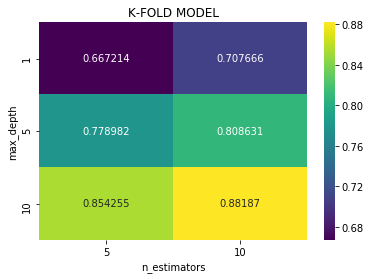

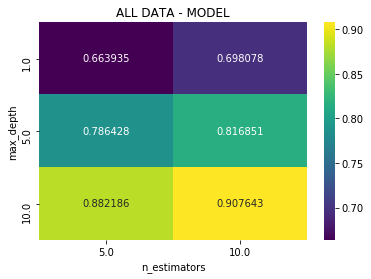

In [60]:
plot(bow_cv_all_scores)
plot2(cv_scores_bow_alldata_table)

### ROC Curve - BoW

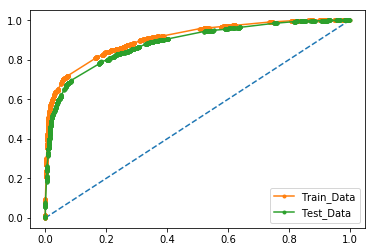

The AUC Score of Train Data using Bag of Words is --  0.9074542829638645
The AUC Score of Test  Data using Bag of Words is --  0.8854695782436641


In [61]:
auc_bow_train, auc_bow_test  = auc_roc(y_train, pred_bow_train, y_test, pred_bow_test)
print("The AUC Score of Train Data using Bag of Words is -- ",auc_bow_train)
print("The AUC Score of Test  Data using Bag of Words is -- ", auc_bow_test)

### Confusion Matrix - BoW

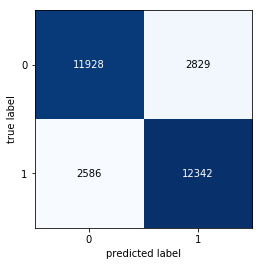

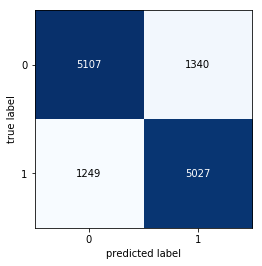

In [62]:
Confusion_Matrix(y_train,pred_bow_train)
Confusion_Matrix(y_test,pred_bow_test)

## [5.1.2] Top 20 important features of positive class from<font color='red'> SET 1</font>

In [63]:
features = np.asarray(Bow_Vect.get_feature_names())
feature_importance = bow_best_grid_estimator.feature_importances_
print(type(features), type(feature_importance))
print(features.shape, feature_importance.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(3000,) (3000,)


In [64]:
#https://stackoverflow.com/questions/26984414/efficiently-sorting-a-numpy-array-in-descending-order
importances = pd.DataFrame(data = np.column_stack((feature_importance,features)), columns = ["Gain", "feature_name"])
importances2 = importances.sort_values(by = 'Gain', ascending = False)
Top20Features = importances2[0:20]
Top20Features

,Gain,feature_name
447,9.965024320769804e-05,chew
2231,9.938409165732929e-09,sadly
1505,9.898823308442095e-05,live
2754,9.872287894503569e-08,trash
1285,9.866506021317206e-05,ice
1075,9.842894399961235e-05,gas
2931,9.82193831317191e-07,wilton
219,9.781414135930947e-05,began
877,9.764124236871438e-05,except
2370,9.72820770092796e-08,sign


In [65]:
pip install wordcloud


The following command must be run outside of the IPython shell:

    $ pip install wordcloud

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [66]:
from wordcloud import WordCloud, STOPWORDS

Used the below link for the Word Cloud Code
[https://www.kaggle.com/y983zhan/word-cloud-with-python]

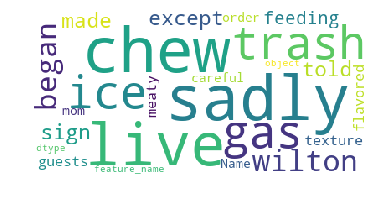

In [67]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib as mpl
#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
#mpl.rcParams['font.size']=40                #10 
#mpl.rcParams['savefig.dpi']=100             #72 
#mpl.rcParams['figure.subplot.bottom']=.1 

wordcloud = WordCloud(
                          background_color='white',
                         ).generate(str(Top20Features['feature_name']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
#fig.savefig("word1.png", dpi=900)

** Adding New Features **

In [68]:
bow_best_parameters_FE, bow_best_grid_estimator_FE, bow_grid_score_FE, bow_cv_all_scores_FE = Grid_Search_CV(Bow_train_withFE, y_train)
cv_scores_bow_alldata_FE, cv_scores_bow_alldata_table_FE = Auc_all_data(Bow_train_withFE, y_train)

print("Best Parameters after Feature Engineering are ---->  ", bow_best_parameters_FE)
print("=====================================================================")
print("Best Auc Score after Feature Engineering is ----> ",bow_grid_score_FE)
print("")
print("")
#Train Data
print("The CV Score table after Feature Engineering for different Hyperparameter are --->")
print("==================================================================================")
score = bow_cv_all_scores_FE.drop('params', axis = 1)
print(score)

The Auc score for whole X_Trian data for different max_depth & n_estimators is ----------->
   max_depth  n_estimators  cv_score
0        1.0           5.0  0.751960
1        1.0          10.0  0.783546
2        5.0           5.0  0.851473
3        5.0          10.0  0.863465
4       10.0           5.0  0.923019
5       10.0          10.0  0.941303
Best Parameters after Feature Engineering are ---->   {'max_depth': 10, 'n_estimators': 10}
Best Auc Score after Feature Engineering is ---->  0.9147661409662662


The CV Score table after Feature Engineering for different Hyperparameter are --->
   mean_test_score  max_depth  n_estimators
0         0.752773          1             5
1         0.781958          1            10
2         0.842732          5             5
3         0.853739          5            10
4         0.896178         10             5
5         0.914766         10            10


In [69]:
bow_best_grid_estimator_FE

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [70]:
#Lets build the Actual Model with the Optimized K
#optimal_DT = DecisionTreeClassifier(best_parameters)

#Fit the Model
optimal_DT = bow_best_grid_estimator_FE.fit(Bow_train_withFE, y_train)

#Predict the AUC on Test Data
pred_bow_train_FE = optimal_DT.predict_proba(Bow_train_withFE)
pred_bow_test_FE = optimal_DT.predict_proba(Bow_test_withFE)

## Representation of Results with FE <font color='red'> SET 1</font>

### Cross Validation Score - Train & Test Data (with FE)

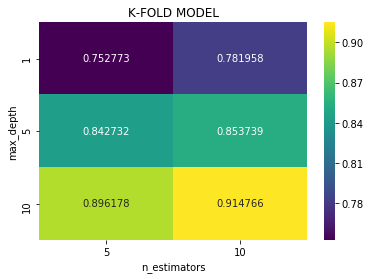

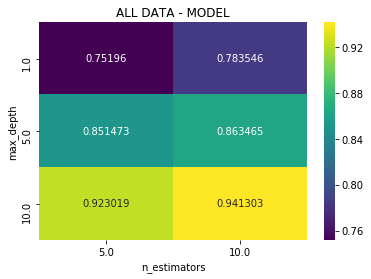

In [71]:
plot(bow_cv_all_scores_FE)
plot2(cv_scores_bow_alldata_table_FE)

### ROC Curve - BoW with FE

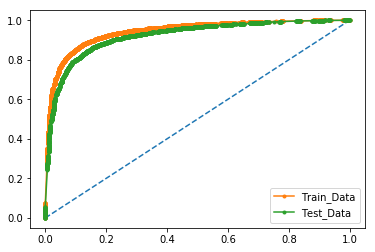

The AUC Score of Train Data using Bag of Words is --  0.941854683057384
The AUC Score of Test  Data using Bag of Words is --  0.921014158887148


In [72]:
auc_bow_train_FE, auc_bow_test_FE  = auc_roc(y_train, pred_bow_train_FE, y_test, pred_bow_test_FE)
print("The AUC Score of Train Data using Bag of Words is -- ",auc_bow_train_FE)
print("The AUC Score of Test  Data using Bag of Words is -- ", auc_bow_test_FE)

### Confusion Matrix - BoW with FE

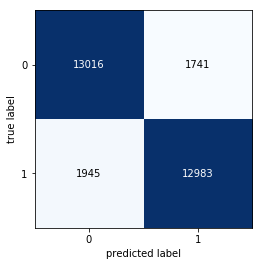

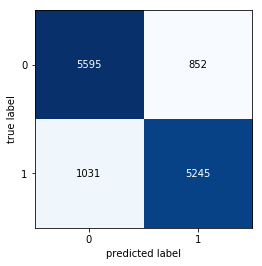

In [73]:
Confusion_Matrix(y_train,pred_bow_train_FE)
Confusion_Matrix(y_test,pred_bow_test_FE)

## [5.2] Applying GBDT on TFIDF,<font color='red'> SET 2</font>

In [74]:
tfidf_best_parameters, tfidf_best_grid_estimator, tfidf_best_auc_score, tfidf_cv_all_scores = Grid_Search_CV(tfidf_train, y_train)
print("Best Parameters are ---->  ",tfidf_best_parameters)
print("======================================================================")
print("Best Auc Score is ----> ",tfidf_best_auc_score)
print("")
print("")
#Train Data
print("The CV Score table for different Hyperparameter are --->")
print("=========================================================")
score = tfidf_cv_all_scores.drop('params', axis = 1)
print(score)

Best Parameters are ---->   {'max_depth': 10, 'n_estimators': 10}
Best Auc Score is ---->  0.889752697712611


The CV Score table for different Hyperparameter are --->
   mean_test_score  max_depth  n_estimators
0         0.673872          1             5
1         0.716433          1            10
2         0.782541          5             5
3         0.813289          5            10
4         0.858570         10             5
5         0.889753         10            10


In [75]:
cv_scores_tfidf_alldata, cv_scores_tfidf_alldata_table = Auc_all_data(tfidf_train, y_train)

The Auc score for whole X_Trian data for different max_depth & n_estimators is ----------->
   max_depth  n_estimators  cv_score
0        1.0           5.0  0.674597
1        1.0          10.0  0.718064
2        5.0           5.0  0.797251
3        5.0          10.0  0.826694
4       10.0           5.0  0.882736
5       10.0          10.0  0.915666


In [76]:
tfidf_best_grid_estimator

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [77]:
#Lets build the Actual Model with the Optimized K
#optimal_DT = DecisionTreeClassifier(best_parameters)

#Fit the Model
optimal_DT = tfidf_best_grid_estimator.fit(tfidf_train, y_train)

#Predict the AUC on Test Data
pred_tfidf_train = tfidf_best_grid_estimator.predict_proba(tfidf_train)
pred_tfidf_test = tfidf_best_grid_estimator.predict_proba(tfidf_test)

## Representation of Results <font color='red'> SET 2</font>

### Cross Validation Score - Train & Test Data 

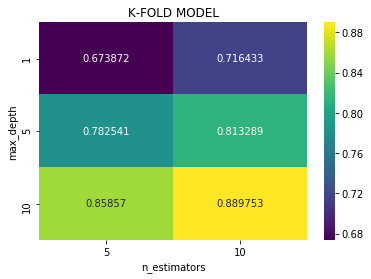

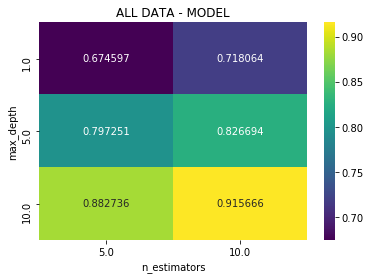

In [78]:
plot(tfidf_cv_all_scores)
plot2(cv_scores_tfidf_alldata_table)

### ROC Curve - TfIDF

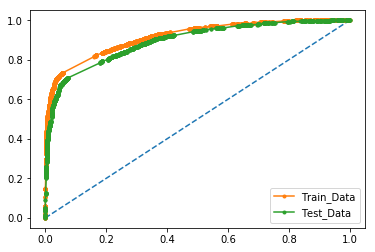

The AUC Score of Train Data using TfIDF is --  0.9168167489463644
The AUC Score of Test  Data using TfIDF is --  0.894431385075128


In [79]:
auc_tfidf_train, auc_tfidf_test  = auc_roc(y_train, pred_tfidf_train, y_test, pred_tfidf_test)
print("The AUC Score of Train Data using TfIDF is -- ",auc_tfidf_train)
print("The AUC Score of Test  Data using TfIDF is -- ", auc_tfidf_test)

### Confusion Matrix - TfIDF

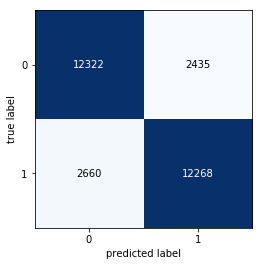

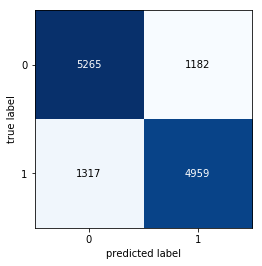

In [80]:
Confusion_Matrix(y_train,pred_tfidf_train)
Confusion_Matrix(y_test,pred_tfidf_test)

## [5.2.2] Top 20 important features of positive class from<font color='red'> SET 2</font>

In [81]:
features = np.asarray(tf_idf_vect.get_feature_names())
feature_importance = tfidf_best_grid_estimator.feature_importances_
print(type(features), type(feature_importance))
print(features.shape, feature_importance.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(3000,) (3000,)


In [82]:
#https://stackoverflow.com/questions/26984414/efficiently-sorting-a-numpy-array-in-descending-order
importances = pd.DataFrame(data = np.column_stack((feature_importance,features)), columns = ["Gain", "feature_name"])
importances2 = importances.sort_values(by = 'Gain', ascending = False)
Top20Features = importances2[0:20]
Top20Features

,Gain,feature_name
497,9.873102619154825e-05,close
1665,9.858321232394017e-09,moist
2067,9.820368882480063e-08,quality
2762,9.816876434443394e-09,trees
2303,9.79801507532951e-07,sell
1088,9.788202023071796e-05,gift
918,9.756958418310276e-05,fan
1295,9.626814481006836e-05,imagine
30,9.58383424652482e-07,adds
1165,9.5805958682412e-06,gums


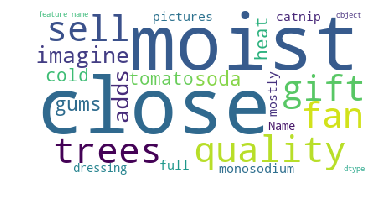

In [83]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib as mpl
#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
#mpl.rcParams['font.size']=40                #10 
#mpl.rcParams['savefig.dpi']=100             #72 
#mpl.rcParams['figure.subplot.bottom']=.1 

wordcloud = WordCloud(
                          background_color='white',
                         ).generate(str(Top20Features['feature_name']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
#fig.savefig("word1.png", dpi=900)

### Added Features

In [84]:
tfidf_best_parameters_FE, tfidf_best_grid_estimator_FE, tfidf_grid_score_FE, tfidf_cv_all_scores_FE = Grid_Search_CV(tfidf_train_with_FE, y_train)
cv_scores_tfidf_alldata_FE, cv_scores_tfidf_alldata_table_FE= Auc_all_data(tfidf_train_with_FE, y_train)

print("Best Parameters after Feature Engineering are ---->  ", tfidf_best_parameters_FE)
print("=====================================================================")
print("Best Auc Score after Feature Engineering is ----> ",tfidf_grid_score_FE)
print("")
print("")
#Train Data
print("The CV Score table after Feature Engineering for different Hyperparameter are --->")
print("==================================================================================")
score = tfidf_cv_all_scores_FE.drop('params', axis = 1)
print(score)

The Auc score for whole X_Trian data for different max_depth & n_estimators is ----------->
   max_depth  n_estimators  cv_score
0        1.0           5.0  0.751960
1        1.0          10.0  0.783546
2        5.0           5.0  0.855314
3        5.0          10.0  0.867470
4       10.0           5.0  0.927004
5       10.0          10.0  0.944915
Best Parameters after Feature Engineering are ---->   {'max_depth': 10, 'n_estimators': 10}
Best Auc Score after Feature Engineering is ---->  0.9181120727508643


The CV Score table after Feature Engineering for different Hyperparameter are --->
   mean_test_score  max_depth  n_estimators
0         0.752773          1             5
1         0.784791          1            10
2         0.846999          5             5
3         0.858043          5            10
4         0.902496         10             5
5         0.918112         10            10


In [85]:
tfidf_best_grid_estimator_FE

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [86]:
#Lets build the Actual Model with the Optimized K
#optimal_DT = DecisionTreeClassifier(best_parameters)

#Fit the Model
optimal_DT = tfidf_best_grid_estimator_FE.fit(tfidf_train_with_FE, y_train)

#Predict the AUC on Test Data
pred_tfidf_train_FE = optimal_DT.predict_proba(tfidf_train_with_FE)
pred_tfidf_test_FE = optimal_DT.predict_proba(tfidf_test_with_FE)

## Representation of Results with FE <font color='red'> SET 2</font>

### Cross Validation Score - Train & Test Data (with FE)

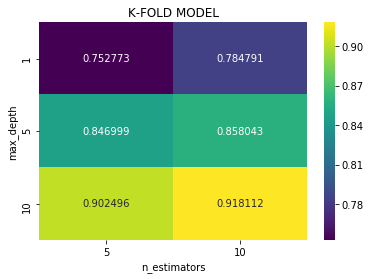

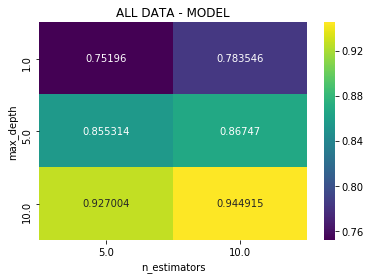

In [87]:
plot(tfidf_cv_all_scores_FE)
plot2(cv_scores_tfidf_alldata_table_FE)

### ROC Curve - TfIDF (with FE)

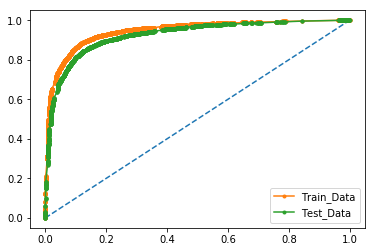

The AUC Score of Train Data using TFIDF is --  0.9446791210718317
The AUC Score of Test  Data using TFIDF is --  0.9254421105641202


In [88]:
auc_tfidf_train_FE, auc_tfidf_test_FE  = auc_roc(y_train, pred_tfidf_train_FE, y_test, pred_tfidf_test_FE)
print("The AUC Score of Train Data using TFIDF is -- ",auc_tfidf_train_FE)
print("The AUC Score of Test  Data using TFIDF is -- ", auc_tfidf_test_FE)

### Confusion Matrix - TfIDF (with FE)

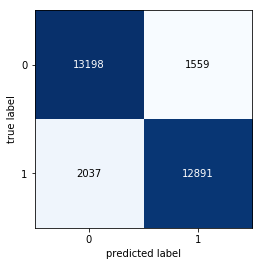

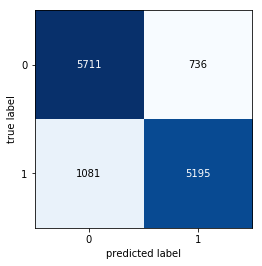

In [89]:
Confusion_Matrix(y_train,pred_tfidf_train_FE)
Confusion_Matrix(y_test,pred_tfidf_test_FE)

## [5.3] Applying GBDT on Average Word2Vec,<font color='red'> SET 3</font>

In [90]:
avgw2v_best_parameters, avgw2v_best_grid_estimator, avgw2v_best_auc_score, avgw2v_cv_all_scores = Grid_Search_CV(avgw2v_train, y_train)
print("Best Parameters are ---->  ",avgw2v_best_parameters)
print("======================================================================")
print("Best Auc Score is ----> ",avgw2v_best_auc_score)
print("")
print("")
#Train Data
print("The CV Score table for different Hyperparameter are --->")
print("=========================================================")
score = avgw2v_cv_all_scores.drop('params', axis = 1)
print(score)

Best Parameters are ---->   {'max_depth': 10, 'n_estimators': 10}
Best Auc Score is ---->  0.9557113003684714


The CV Score table for different Hyperparameter are --->
   mean_test_score  max_depth  n_estimators
0         0.755958          1             5
1         0.769178          1            10
2         0.829562          5             5
3         0.844069          5            10
4         0.937100         10             5
5         0.955711         10            10


In [91]:
cv_scores_avgw2v_alldata, cv_scores_avgw2v_alldata_table = Auc_all_data(avgw2v_train, y_train)

The Auc score for whole X_Trian data for different max_depth & n_estimators is ----------->
   max_depth  n_estimators  cv_score
0        1.0           5.0  0.755547
1        1.0          10.0  0.769845
2        5.0           5.0  0.842510
3        5.0          10.0  0.859368
4       10.0           5.0  0.973278
5       10.0          10.0  0.986077


In [92]:
avgw2v_best_grid_estimator

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [93]:
#Lets build the Actual Model with the Optimized K
#optimal_DT = DecisionTreeClassifier(best_parameters)

#Fit the Model
optimal_DT = avgw2v_best_grid_estimator.fit(avgw2v_train, y_train)

#Predict the AUC on Test Data
pred_avgw2v_train = avgw2v_best_grid_estimator.predict_proba(avgw2v_train)
pred_avgw2v_test = avgw2v_best_grid_estimator.predict_proba(avgw2v_test)

## Representation of Results <font color='red'> SET 3</font>

### Cross Validation Score - Train & Test Data (AvgW2V)

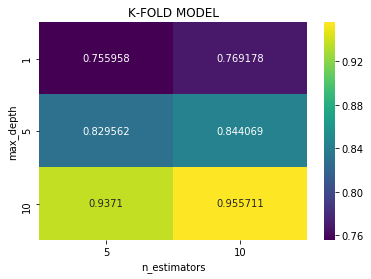

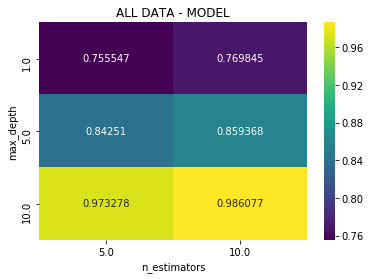

In [94]:
plot(avgw2v_cv_all_scores)
plot2(cv_scores_avgw2v_alldata_table)

### ROC Curve - AvgW2V

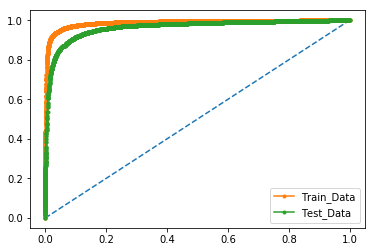

The AUC Score of Train Data using AvgW2V is --  0.9871344142380593
The AUC Score of Test  Data using AvgW2V is --  0.9636959418973732


In [95]:
auc_avgw2v_train, auc_avgw2v_test  = auc_roc(y_train, pred_avgw2v_train, y_test, pred_avgw2v_test)
print("The AUC Score of Train Data using AvgW2V is -- ",auc_avgw2v_train)
print("The AUC Score of Test  Data using AvgW2V is -- ", auc_avgw2v_test)

### Confusion Matrix - AvgW2V

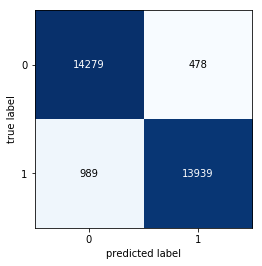

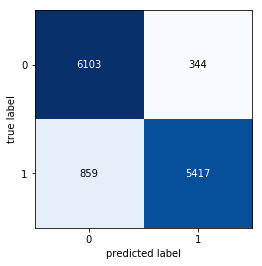

In [96]:
Confusion_Matrix(y_train,pred_avgw2v_train)
Confusion_Matrix(y_test,pred_avgw2v_test)

### Adding New Features

In [97]:
avgw2v_best_parameters_FE, avgw2v_best_grid_estimator_FE, avgw2v_grid_score_FE, avgw2v_cv_all_scores_FE = Grid_Search_CV(avgw2v_train_with_FE, y_train)
cv_scores_avgw2v_alldata_FE, cv_scores_avgw2v_alldata_table_FE= Auc_all_data(avgw2v_train_with_FE, y_train)

print("Best Parameters after Feature Engineering are ---->  ", avgw2v_best_parameters_FE)
print("=====================================================================")
print("Best Auc Score after Feature Engineering is ----> ",avgw2v_grid_score_FE)
print("")
print("")
#Train Data
print("The CV Score table after Feature Engineering for different Hyperparameter are --->")
print("==================================================================================")
score = avgw2v_cv_all_scores_FE.drop('params', axis = 1)
print(score)

The Auc score for whole X_Trian data for different max_depth & n_estimators is ----------->
   max_depth  n_estimators  cv_score
0        1.0           5.0  0.802983
1        1.0          10.0  0.828613
2        5.0           5.0  0.881371
3        5.0          10.0  0.891520
4       10.0           5.0  0.979975
5       10.0          10.0  0.988088
Best Parameters after Feature Engineering are ---->   {'max_depth': 10, 'n_estimators': 10}
Best Auc Score after Feature Engineering is ---->  0.9626596864636575


The CV Score table after Feature Engineering for different Hyperparameter are --->
   mean_test_score  max_depth  n_estimators
0         0.802702          1             5
1         0.828750          1            10
2         0.871677          5             5
3         0.881065          5            10
4         0.947732         10             5
5         0.962660         10            10


In [98]:
avgw2v_best_grid_estimator_FE

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [99]:
#Lets build the Actual Model with the Optimized K
#optimal_DT = DecisionTreeClassifier(best_parameters)

#Fit the Model
optimal_DT = avgw2v_best_grid_estimator_FE.fit(avgw2v_train_with_FE, y_train)

#Predict the AUC on Test Data
pred_avgw2v_train_FE = optimal_DT.predict_proba(avgw2v_train_with_FE)
pred_avgw2v_test_FE = optimal_DT.predict_proba(avgw2v_test_with_FE)

## Representation of Results with FE <font color='red'> SET 3</font>

### Cross Validation Score - Train & Test Data (with FE)

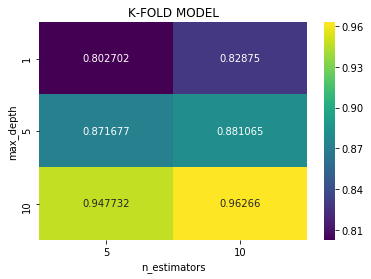

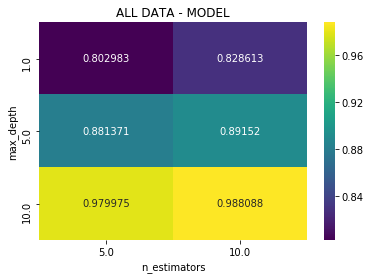

In [100]:
plot(avgw2v_cv_all_scores_FE)
plot2(cv_scores_avgw2v_alldata_table_FE)

### ROC Curve - AvgW2V (with FE)

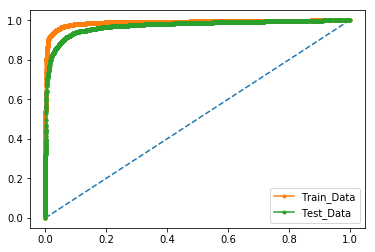

The AUC Score of Train Data using AvgW2V is --  0.9887761111027585
The AUC Score of Test  Data using AvgW2V is --  0.971165856659532


In [101]:
auc_avgw2v_train_FE, auc_avgw2v_test_FE  = auc_roc(y_train, pred_avgw2v_train_FE, y_test, pred_avgw2v_test_FE)
print("The AUC Score of Train Data using AvgW2V is -- ",auc_avgw2v_train_FE)
print("The AUC Score of Test  Data using AvgW2V is -- ", auc_avgw2v_test_FE)

### Confusion Matrix - AvgW2V (with FE)

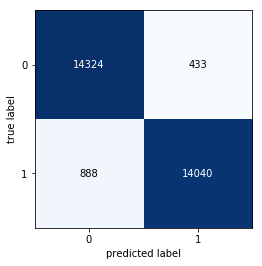

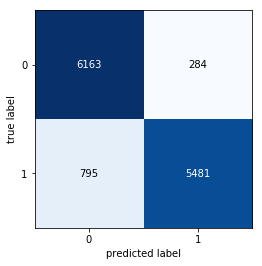

In [102]:
Confusion_Matrix(y_train,pred_avgw2v_train_FE)
Confusion_Matrix(y_test,pred_avgw2v_test_FE)

## [5.4] Applying GBDT on Tfidf-W2V,<font color='red'> SET 4</font>

In [103]:
tfidfw2v_best_parameters, tfidfw2v_best_grid_estimator, tfidfw2v_best_auc_score, tfidfw2v_cv_all_scores = Grid_Search_CV(tfidf_w2v_train, y_train)
print("Best Parameters are ---->  ",tfidfw2v_best_parameters)
print("======================================================================")
print("Best Auc Score is ----> ",tfidfw2v_best_auc_score)
print("")
print("")
#Train Data
print("The CV Score table for different Hyperparameter are --->")
print("=========================================================")
score = tfidfw2v_cv_all_scores.drop('params', axis = 1)
print(score)

Best Parameters are ---->   {'max_depth': 10, 'n_estimators': 10}
Best Auc Score is ---->  0.9534698199902442


The CV Score table for different Hyperparameter are --->
   mean_test_score  max_depth  n_estimators
0         0.722573          1             5
1         0.736955          1            10
2         0.809784          5             5
3         0.824145          5            10
4         0.931275         10             5
5         0.953470         10            10


In [104]:
cv_scores_tfidfw2v_alldata, cv_scores_tfidfw2v_alldata_table = Auc_all_data(tfidf_w2v_train, y_train)

The Auc score for whole X_Trian data for different max_depth & n_estimators is ----------->
   max_depth  n_estimators  cv_score
0        1.0           5.0  0.727413
1        1.0          10.0  0.738123
2        5.0           5.0  0.823761
3        5.0          10.0  0.841923
4       10.0           5.0  0.974365
5       10.0          10.0  0.987895


In [105]:
tfidfw2v_best_grid_estimator

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [106]:
#Lets build the Actual Model with the Optimized K
#optimal_DT = DecisionTreeClassifier(best_parameters)

#Fit the Model
optimal_DT = tfidfw2v_best_grid_estimator.fit(tfidf_w2v_train, y_train)

#Predict the AUC on Test Data
pred_tfidfw2v_train = tfidfw2v_best_grid_estimator.predict_proba(tfidf_w2v_train)
pred_tfidfw2v_test = tfidfw2v_best_grid_estimator.predict_proba(tfidf_w2v_test)

## Representation of Results <font color='red'> SET 4</font>

### Cross Validation Score - Train & Test Data (TfIDF-AvgW2V)

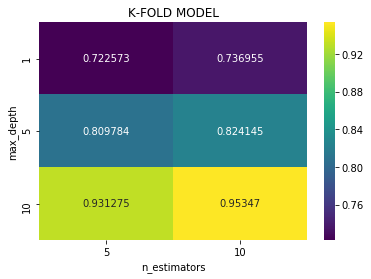

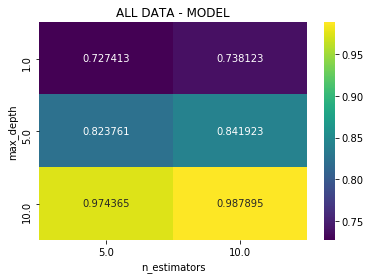

In [107]:
plot(tfidfw2v_cv_all_scores)
plot2(cv_scores_tfidfw2v_alldata_table)

### ROC Curve - TfIDF-AvgW2V

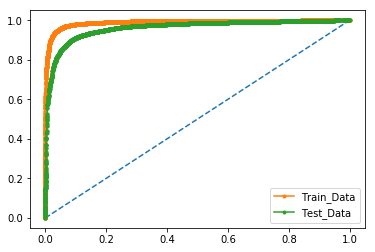

The AUC Score of Train Data using TfIDF-AvgW2V is --  0.9890705378362049
The AUC Score of Test  Data using TfIDF-AvgW2V is --  0.960742816630143


In [108]:
auc_tfidfw2v_train, auc_tfidfw2v_test  = auc_roc(y_train, pred_tfidfw2v_train, y_test, pred_tfidfw2v_test)
print("The AUC Score of Train Data using TfIDF-AvgW2V is -- ",auc_tfidfw2v_train)
print("The AUC Score of Test  Data using TfIDF-AvgW2V is -- ", auc_tfidfw2v_test)

### Confusion Matrix - TfIDF-AvgW2V

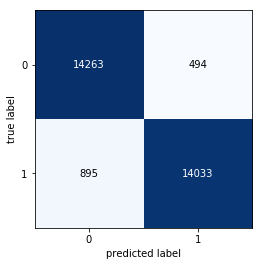

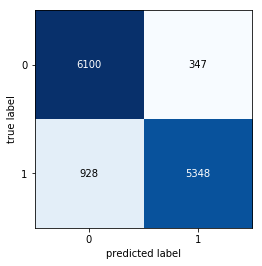

In [109]:
Confusion_Matrix(y_train,pred_tfidfw2v_train)
Confusion_Matrix(y_test,pred_tfidfw2v_test)

### Adding New Features

In [110]:
tfidfw2v_best_parameters_FE, tfidfw2v_best_grid_estimator_FE, tfidfw2v_grid_score_FE, tfidfw2v_cv_all_scores_FE = Grid_Search_CV(tfidf_w2v_train_with_FE, y_train)
cv_scores_tfidfw2v_alldata_FE, cv_scores_tfidfw2v_alldata_table_FE= Auc_all_data(tfidf_w2v_train_with_FE, y_train)

print("Best Parameters after Feature Engineering are ---->  ", tfidfw2v_best_parameters_FE)
print("=====================================================================")
print("Best Auc Score after Feature Engineering is ----> ",tfidfw2v_grid_score_FE)
print("")
print("")
#Train Data
print("The CV Score table after Feature Engineering for different Hyperparameter are --->")
print("==================================================================================")
score = tfidfw2v_cv_all_scores_FE.drop('params', axis = 1)
print(score)

The Auc score for whole X_Trian data for different max_depth & n_estimators is ----------->
   max_depth  n_estimators  cv_score
0        1.0           5.0  0.751960
1        1.0          10.0  0.819065
2        5.0           5.0  0.871544
3        5.0          10.0  0.882480
4       10.0           5.0  0.976761
5       10.0          10.0  0.988515
Best Parameters after Feature Engineering are ---->   {'max_depth': 10, 'n_estimators': 10}
Best Auc Score after Feature Engineering is ---->  0.9603932337171627


The CV Score table after Feature Engineering for different Hyperparameter are --->
   mean_test_score  max_depth  n_estimators
0         0.752773          1             5
1         0.815830          1            10
2         0.862510          5             5
3         0.870989          5            10
4         0.944249         10             5
5         0.960393         10            10


In [111]:
tfidfw2v_best_grid_estimator_FE

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [112]:
#Lets build the Actual Model with the Optimized K
#optimal_DT = DecisionTreeClassifier(best_parameters)

#Fit the Model
optimal_DT = tfidfw2v_best_grid_estimator_FE.fit(tfidf_w2v_train_with_FE, y_train)

#Predict the AUC on Test Data
pred_tfidfw2v_train_FE = optimal_DT.predict_proba(tfidf_w2v_train_with_FE)
pred_tfidfw2v_test_FE = optimal_DT.predict_proba(tfidf_w2v_test_with_FE)

## Representation of Results with FE <font color='red'> SET 4</font>

### Cross Validation Score - Train & Test Data (with FE)

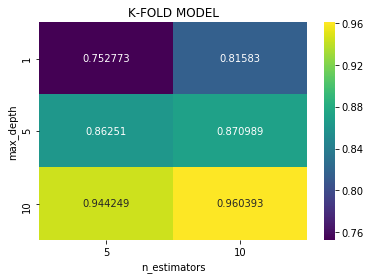

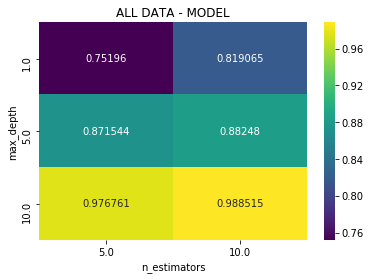

In [113]:
plot(tfidfw2v_cv_all_scores_FE)
plot2(cv_scores_tfidfw2v_alldata_table_FE)

### ROC Curve - TfIDF-AvgW2V (with FE)

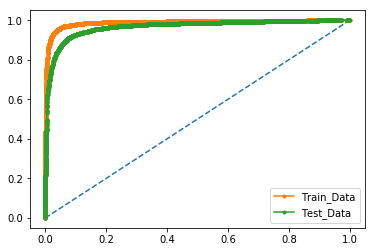

The AUC Score of Train Data using TfIDf-AvgW2V is --  0.9877613647811226
The AUC Score of Test  Data using TfIDF-AvgW2V is --  0.9664906691745401


In [114]:
auc_tfidfw2v_train_FE, auc_tfidfw2v_test_FE  = auc_roc(y_train, pred_tfidfw2v_train_FE, y_test, pred_tfidfw2v_test_FE)
print("The AUC Score of Train Data using TfIDf-AvgW2V is -- ",auc_tfidfw2v_train_FE)
print("The AUC Score of Test  Data using TfIDF-AvgW2V is -- ", auc_tfidfw2v_test_FE)

### Confusion Matrix - Tfidf-AvgW2V (with FE)

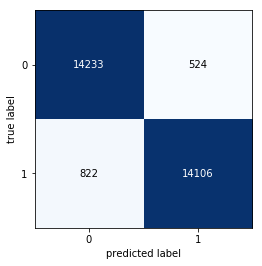

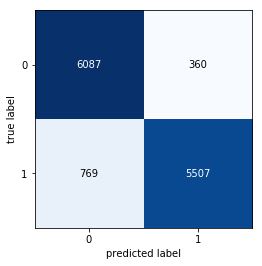

In [115]:
Confusion_Matrix(y_train,pred_tfidfw2v_train_FE)
Confusion_Matrix(y_test,pred_tfidfw2v_test_FE)

# [6] Conclusions

Below link is used to understand how to use the PettyTable library. It is pretty interesting to present lot of results in a table format.

**Source - **http://zetcode.com/python/prettytable/


In [116]:
Bow = cv_scores_bow_alldata_table.sort_values(by = 'cv_score', ascending = False)[:1]
Bow_FE = cv_scores_bow_alldata_table_FE.sort_values(by = 'cv_score', ascending = False)[:1]
Tfidf = cv_scores_tfidf_alldata_table.sort_values(by = 'cv_score', ascending = False)[:1]
Tfidf_FE = cv_scores_tfidf_alldata_table_FE.sort_values(by = 'cv_score', ascending = False)[:1]
avgw2v = cv_scores_avgw2v_alldata_table.sort_values(by = 'cv_score', ascending = False)[:1]
avgw2v_FE = cv_scores_avgw2v_alldata_table_FE.sort_values(by = 'cv_score', ascending = False)[:1]
tfidf_w2v = cv_scores_tfidfw2v_alldata_table.sort_values(by = 'cv_score', ascending = False)[:1]
tfidf_w2v_FE = cv_scores_tfidfw2v_alldata_table_FE.sort_values(by = 'cv_score', ascending = False)[:1]

In [117]:
!pip3 install PTable

  Stored in directory: /tmp/.cache/pip/wheels/22/cc/2e/55980bfe86393df3e9896146a01f6802978d09d7ebcba5ea56
Successfully built PTable
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [118]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Method", "Maximum_Depth", "n_estimators", "Train_Score","Test_Score"]

x.add_row(["BoW", Bow.iloc[0]['max_depth'], Bow.iloc[0]['n_estimators'], Bow.iloc[0]['cv_score'],auc_bow_test])
x.add_row(["BoW-FE", Bow_FE.iloc[0]['max_depth'], Bow_FE.iloc[0]['n_estimators'], Bow_FE.iloc[0]['cv_score'], auc_bow_test_FE])

x.add_row(["TfIDF", Tfidf.iloc[0]['max_depth'], Tfidf.iloc[0]['n_estimators'], Tfidf.iloc[0]['cv_score'], auc_tfidf_test])
x.add_row(["TfIDF-FE", Tfidf_FE.iloc[0]['max_depth'], Tfidf_FE.iloc[0]['n_estimators'], Tfidf_FE.iloc[0]['cv_score'], auc_tfidf_test_FE])

x.add_row(["AvgW2V", avgw2v.iloc[0]['max_depth'], avgw2v.iloc[0]['n_estimators'], avgw2v.iloc[0]['cv_score'], auc_avgw2v_test])
x.add_row(["AvgW2V-FE",avgw2v_FE.iloc[0]['max_depth'], avgw2v_FE.iloc[0]['n_estimators'], avgw2v_FE.iloc[0]['cv_score'], auc_avgw2v_test_FE])

x.add_row(["Tfidf_AvgW2V", tfidf_w2v.iloc[0]['max_depth'], tfidf_w2v.iloc[0]['n_estimators'], tfidf_w2v.iloc[0]['cv_score'], auc_tfidfw2v_test])
x.add_row(["Tfidf_AvgW2V-FE", tfidf_w2v_FE.iloc[0]['max_depth'], tfidf_w2v_FE.iloc[0]['n_estimators'], tfidf_w2v_FE.iloc[0]['cv_score'], auc_tfidfw2v_test_FE])

print(x)

+-----------------+---------------+--------------+--------------------+--------------------+
|      Method     | Maximum_Depth | n_estimators |    Train_Score     |     Test_Score     |
+-----------------+---------------+--------------+--------------------+--------------------+
|       BoW       |      10.0     |     10.0     | 0.9076426938301156 | 0.8854695782436641 |
|      BoW-FE     |      10.0     |     10.0     | 0.9413031867413222 | 0.921014158887148  |
|      TfIDF      |      10.0     |     10.0     | 0.9156655408725316 | 0.894431385075128  |
|     TfIDF-FE    |      10.0     |     10.0     | 0.9449147033133621 | 0.9254421105641202 |
|      AvgW2V     |      10.0     |     10.0     | 0.9860766001761585 | 0.9636959418973732 |
|    AvgW2V-FE    |      10.0     |     10.0     | 0.9880884208602365 | 0.971165856659532  |
|   Tfidf_AvgW2V  |      10.0     |     10.0     | 0.9878945263755149 | 0.960742816630143  |
| Tfidf_AvgW2V-FE |      10.0     |     10.0     | 0.9885149991672889 

## **Observations**

Below are the few observations from the output of the data. We used 25K reviews for the modelling. Below are bullet points of some of the observations we have made in this assignment.

